In [23]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [24]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [25]:
weather_data

,Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,
2021-01-01 00:00:00,0.0,7.2,79.0,9.0
2021-01-01 01:00:00,0.0,7.3,79.0,6.0
2021-01-01 02:00:00,0.0,7.6,78.0,4.0
2021-01-01 03:00:00,0.0,8.2,75.0,4.0
2021-01-01 04:00:00,0.0,7.7,77.0,7.0
...,...,...,...,...
2022-07-31 19:00:00,0.0,26.6,68.0,5.0
2022-07-31 20:00:00,0.0,26.8,65.0,6.0
2022-07-31 21:00:00,0.0,26.7,65.0,5.0


In [26]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [27]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

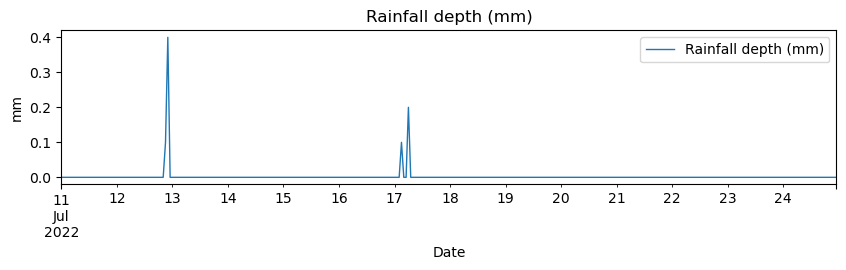

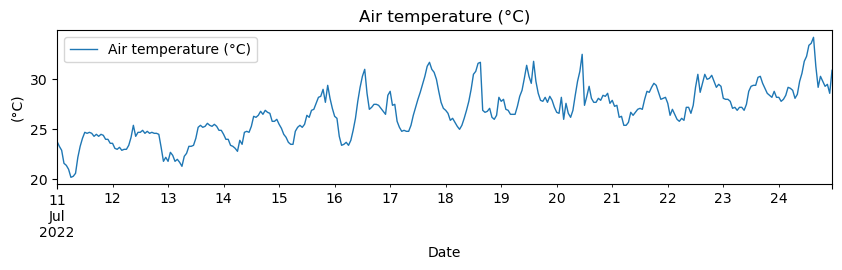

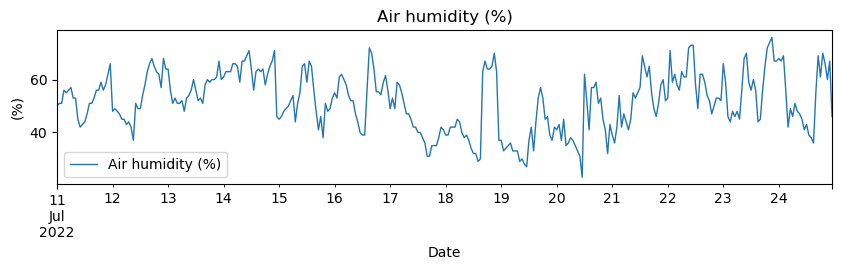

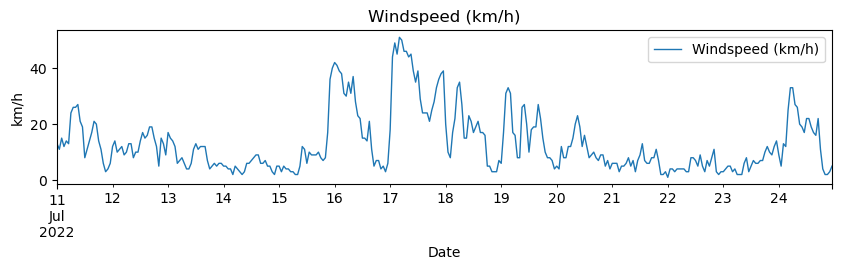

In [28]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-07-11'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

In [29]:
X

,Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h),official_holiday,legally_not_recongnized_holidays,event_day,weekend
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,,,,,
2022-07-11 00:00:00,0.0,23.8,50.0,13.0,0,0,0,0
2022-07-11 01:00:00,0.0,23.3,51.0,11.0,0,0,0,0
2022-07-11 02:00:00,0.0,22.9,51.0,15.0,0,0,0,0
2022-07-11 03:00:00,0.0,21.6,56.0,12.0,0,0,0,0
2022-07-11 04:00:00,0.0,21.4,55.0,14.0,0,0,0,0
...,...,...,...,...,...,...,...,...
2022-07-24 19:00:00,0.0,29.8,70.0,4.0,0,0,0,1
2022-07-24 20:00:00,0.0,29.3,66.0,2.0,0,0,0,1
2022-07-24 21:00:00,0.0,29.5,60.0,2.0,0,0,0,1


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49506D+00    |proj g|=  7.68593D+00


 This problem is unconstrained.



At iterate    5    f=  1.86549D+00    |proj g|=  5.41621D-01

At iterate   10    f=  1.74871D+00    |proj g|=  1.81481D-01

At iterate   15    f=  1.70861D+00    |proj g|=  1.19193D-01

At iterate   20    f=  1.70574D+00    |proj g|=  1.48052D-02

At iterate   25    f=  1.70543D+00    |proj g|=  1.66537D-02

At iterate   30    f=  1.70499D+00    |proj g|=  3.12023D-02

At iterate   35    f=  1.70373D+00    |proj g|=  6.86890D-02

At iterate   40    f=  1.70221D+00    |proj g|=  1.63831D-02

At iterate   45    f=  1.70194D+00    |proj g|=  8.95537D-03

At iterate   50    f=  1.70119D+00    |proj g|=  3.52530D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

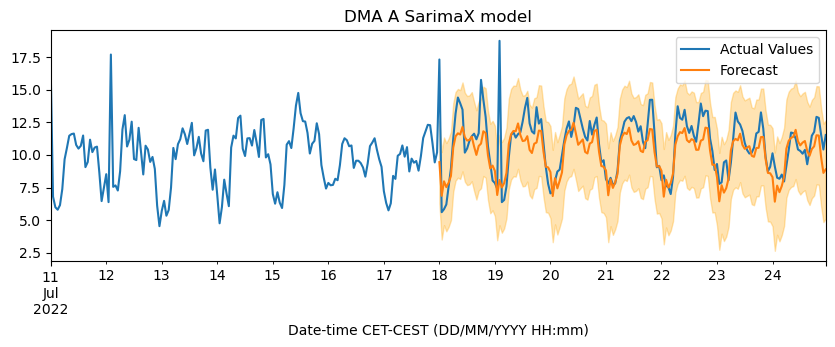

Performance indicators
DMA A SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.59            7.86             1.07           10.52 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.74            7.56             1.98           12.28 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02352D+00    |proj g|=  6.00640D-01


 This problem is unconstrained.



At iterate    5    f=  8.76605D-01    |proj g|=  3.68656D-01

At iterate   10    f=  7.97697D-01    |proj g|=  8.15076D-02

At iterate   15    f=  7.82843D-01    |proj g|=  2.06198D-01

At iterate   20    f=  7.78093D-01    |proj g|=  3.88625D-02

At iterate   25    f=  7.77324D-01    |proj g|=  1.47179D-02

At iterate   30    f=  7.75702D-01    |proj g|=  3.21755D-02

At iterate   35    f=  7.74941D-01    |proj g|=  8.53975D-02

At iterate   40    f=  7.74180D-01    |proj g|=  1.61878D-01

At iterate   45    f=  7.72275D-01    |proj g|=  1.32768D-01

At iterate   50    f=  7.71628D-01    |proj g|=  1.02283D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

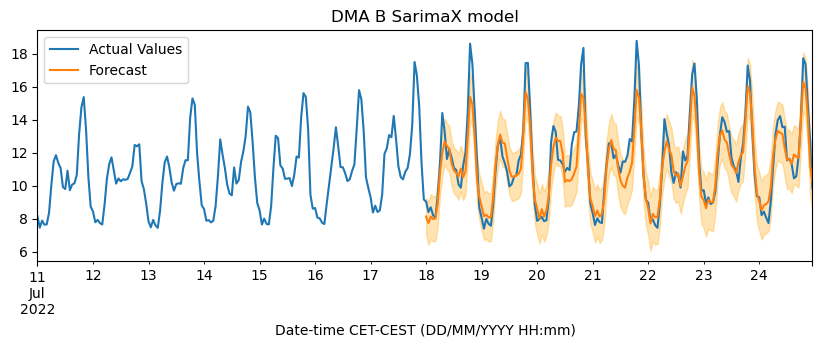

Performance indicators
DMA B SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.92            3.21             0.73           4.86 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.16            7.90             2.17           12.22 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49445D-01    |proj g|=  1.44170D+00


 This problem is unconstrained.



At iterate    5    f=  8.34169D-01    |proj g|=  1.82385D+00

At iterate   10    f=  7.32775D-01    |proj g|=  5.85530D-01

At iterate   15    f=  7.22831D-01    |proj g|=  4.97518D-01

At iterate   20    f=  7.14196D-01    |proj g|=  6.09364D-01

At iterate   25    f=  7.07435D-01    |proj g|=  4.15209D-01

At iterate   30    f=  7.03011D-01    |proj g|=  5.06820D-02

At iterate   35    f=  6.98260D-01    |proj g|=  1.58587D-01

At iterate   40    f=  6.93311D-01    |proj g|=  3.05004D-02

At iterate   45    f=  6.89061D-01    |proj g|=  2.17921D-01

At iterate   50    f=  6.85674D-01    |proj g|=  2.70359D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

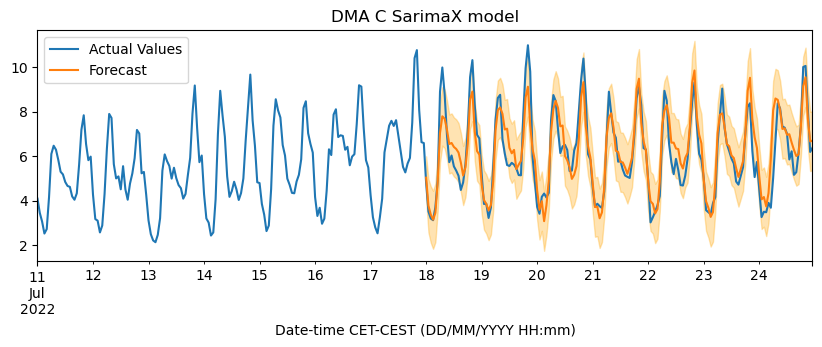

Performance indicators
DMA C SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.75            2.20             0.59           3.54 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.74            4.83             1.50           8.07 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44038D+00    |proj g|=  4.60370D-01


 This problem is unconstrained.



At iterate    5    f=  2.22695D+00    |proj g|=  1.95953D-01

At iterate   10    f=  2.19111D+00    |proj g|=  1.15712D-01

At iterate   15    f=  2.18780D+00    |proj g|=  9.43003D-03

At iterate   20    f=  2.18641D+00    |proj g|=  8.00277D-03

At iterate   25    f=  2.18480D+00    |proj g|=  8.24882D-02

At iterate   30    f=  2.18387D+00    |proj g|=  6.55609D-03

At iterate   35    f=  2.18383D+00    |proj g|=  3.64464D-03

At iterate   40    f=  2.18377D+00    |proj g|=  8.40274D-03

At iterate   45    f=  2.18368D+00    |proj g|=  1.27472D-02

At iterate   50    f=  2.18361D+00    |proj g|=  3.55728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

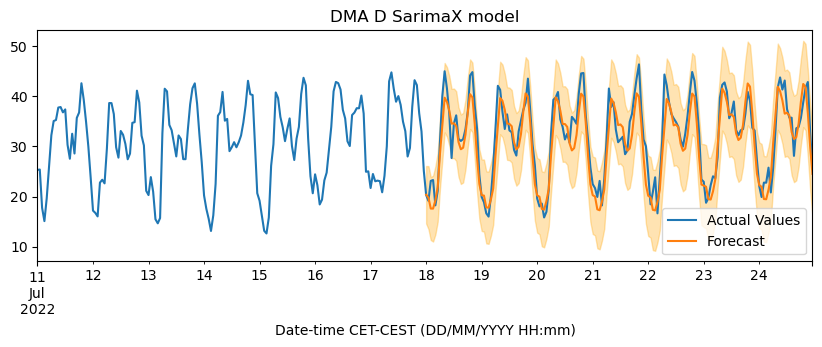

Performance indicators
DMA D SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.70            6.85             2.60           12.15 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.97            14.29             6.85           28.11 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21486D+00    |proj g|=  7.93750D-01


 This problem is unconstrained.



At iterate    5    f=  1.87881D+00    |proj g|=  8.31111D-01

At iterate   10    f=  1.77368D+00    |proj g|=  1.13459D-01

At iterate   15    f=  1.76206D+00    |proj g|=  7.89374D-02

At iterate   20    f=  1.75896D+00    |proj g|=  2.44964D-02

At iterate   25    f=  1.75687D+00    |proj g|=  1.40198D-02

At iterate   30    f=  1.75588D+00    |proj g|=  3.53458D-02

At iterate   35    f=  1.75513D+00    |proj g|=  4.14116D-02

At iterate   40    f=  1.75465D+00    |proj g|=  3.18506D-02

At iterate   45    f=  1.75412D+00    |proj g|=  8.64521D-03

At iterate   50    f=  1.75372D+00    |proj g|=  2.93087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

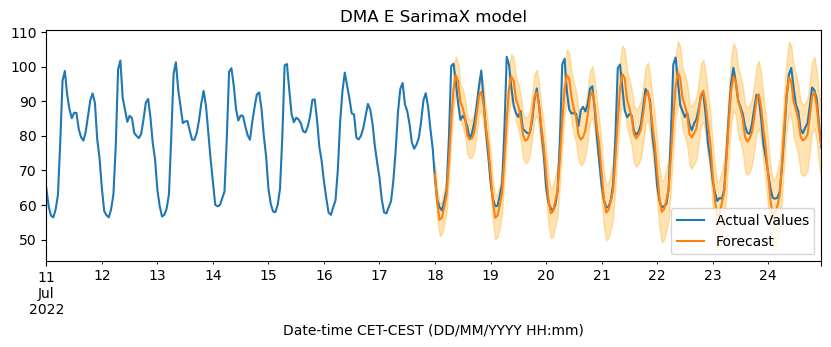

Performance indicators
DMA E SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.41            16.31             3.07           22.79 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
10.98            21.78             10.71           43.47 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51670D+00    |proj g|=  4.39747D-01


 This problem is unconstrained.



At iterate    5    f=  1.48645D+00    |proj g|=  5.49840D-01

At iterate   10    f=  1.45685D+00    |proj g|=  3.80968D-01

At iterate   15    f=  1.43598D+00    |proj g|=  1.23813D-01

At iterate   20    f=  1.43353D+00    |proj g|=  2.88644D-01

At iterate   25    f=  1.43061D+00    |proj g|=  4.14795D-02

At iterate   30    f=  1.43010D+00    |proj g|=  4.59372D-02

At iterate   35    f=  1.42950D+00    |proj g|=  3.49512D-02

At iterate   40    f=  1.42918D+00    |proj g|=  6.21794D-03

At iterate   45    f=  1.42904D+00    |proj g|=  1.31004D-02

At iterate   50    f=  1.42806D+00    |proj g|=  1.20976D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

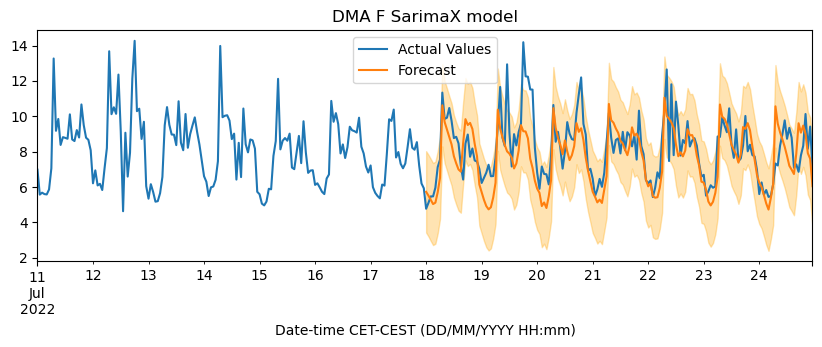

Performance indicators
DMA F SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.97            2.06             1.08           4.11 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.43            3.30             1.38           6.10 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45883D+00    |proj g|=  3.40918D-01


 This problem is unconstrained.



At iterate    5    f=  1.43486D+00    |proj g|=  5.81500D-02

At iterate   10    f=  1.42979D+00    |proj g|=  1.31416D-02

At iterate   15    f=  1.42776D+00    |proj g|=  2.86766D-02

At iterate   20    f=  1.42564D+00    |proj g|=  4.16823D-02

At iterate   25    f=  1.42487D+00    |proj g|=  1.76618D-02

At iterate   30    f=  1.42329D+00    |proj g|=  1.11804D-02

At iterate   35    f=  1.42290D+00    |proj g|=  1.28081D-02

At iterate   40    f=  1.42245D+00    |proj g|=  3.59939D-02

At iterate   45    f=  1.42110D+00    |proj g|=  1.92466D-02

At iterate   50    f=  1.42028D+00    |proj g|=  2.55410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

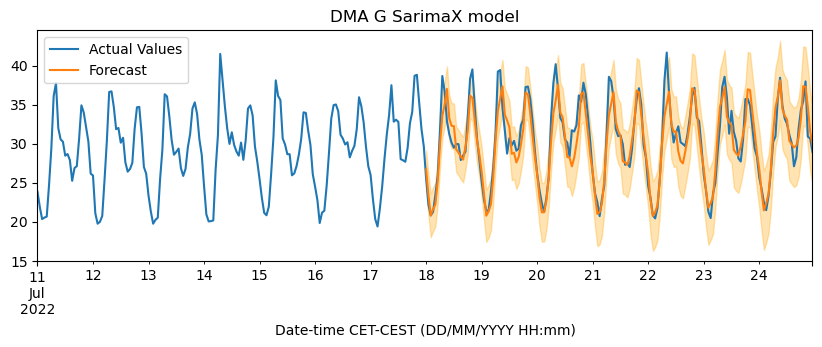

Performance indicators
DMA G SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.59            5.09             1.39           8.07 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.12            10.48             4.38           18.97 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66564D+00    |proj g|=  4.51359D-01


 This problem is unconstrained.



At iterate    5    f=  1.62002D+00    |proj g|=  2.92667D-02

At iterate   10    f=  1.61885D+00    |proj g|=  2.00585D-02

At iterate   15    f=  1.61874D+00    |proj g|=  2.51539D-02

At iterate   20    f=  1.61759D+00    |proj g|=  3.07757D-02

At iterate   25    f=  1.61551D+00    |proj g|=  4.84164D-02

At iterate   30    f=  1.61371D+00    |proj g|=  2.95378D-02

At iterate   35    f=  1.61264D+00    |proj g|=  8.50686D-02

At iterate   40    f=  1.61048D+00    |proj g|=  3.93001D-02

At iterate   45    f=  1.60956D+00    |proj g|=  8.72683D-02

At iterate   50    f=  1.60869D+00    |proj g|=  2.53619D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

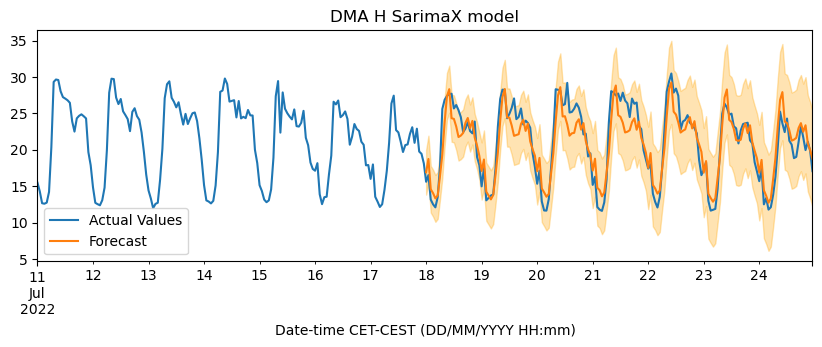

Performance indicators
DMA H SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.75            6.26             1.66           9.67 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.53            9.23             4.50           18.27 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57517D+00    |proj g|=  2.27153D-01


 This problem is unconstrained.



At iterate    5    f=  1.55271D+00    |proj g|=  1.82675D-01

At iterate   10    f=  1.54662D+00    |proj g|=  9.58990D-03

At iterate   15    f=  1.54355D+00    |proj g|=  6.22792D-02

At iterate   20    f=  1.54167D+00    |proj g|=  2.07518D-02

At iterate   25    f=  1.53924D+00    |proj g|=  2.80143D-02

At iterate   30    f=  1.53518D+00    |proj g|=  9.47451D-02

At iterate   35    f=  1.53225D+00    |proj g|=  1.96742D-02

At iterate   40    f=  1.53130D+00    |proj g|=  1.34054D-02

At iterate   45    f=  1.53085D+00    |proj g|=  1.02227D-02

At iterate   50    f=  1.53042D+00    |proj g|=  4.03758D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

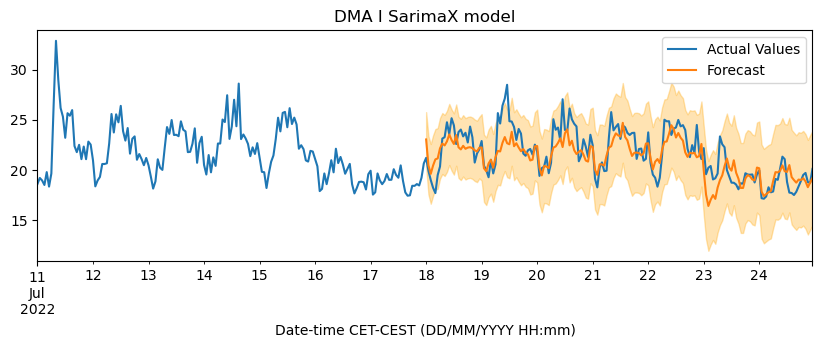

Performance indicators
DMA I SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.31            3.36             1.22           5.90 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.92            3.93             2.14           8.00 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66931D+00    |proj g|=  1.52758D-01


 This problem is unconstrained.



At iterate    5    f=  1.64332D+00    |proj g|=  3.23181D-01

At iterate   10    f=  1.63762D+00    |proj g|=  1.10631D-01

At iterate   15    f=  1.63604D+00    |proj g|=  3.79144D-02

At iterate   20    f=  1.63357D+00    |proj g|=  1.14206D-01

At iterate   25    f=  1.63229D+00    |proj g|=  3.91184D-02

At iterate   30    f=  1.63043D+00    |proj g|=  9.79963D-02

At iterate   35    f=  1.62588D+00    |proj g|=  1.29296D-01

At iterate   40    f=  1.62406D+00    |proj g|=  7.14446D-02

At iterate   45    f=  1.62072D+00    |proj g|=  6.40010D-02

At iterate   50    f=  1.61790D+00    |proj g|=  3.10471D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

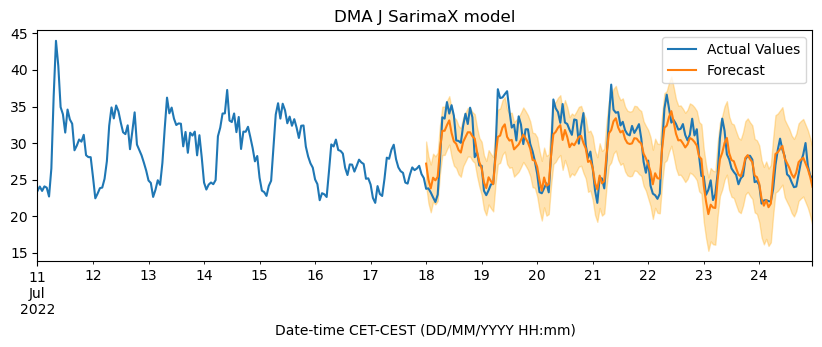

Performance indicators
DMA J SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.01            3.79             1.57           7.37 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.11            6.84             3.71           14.65 



In [30]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 1-Week',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [31]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 1-Week,1.591,7.858,1.067,10.516
DMA B SarimaX 1-Week,0.921,3.213,0.726,4.860
DMA C SarimaX 1-Week,0.752,2.197,0.590,3.539
DMA D SarimaX 1-Week,2.702,6.852,2.599,12.153
DMA E SarimaX 1-Week,3.407,16.306,3.073,22.786
DMA F SarimaX 1-Week,0.971,2.061,1.083,4.114
DMA G SarimaX 1-Week,1.586,5.094,1.388,8.068
DMA H SarimaX 1-Week,1.746,6.259,1.660,9.666
DMA I SarimaX 1-Week,1.311,3.363,1.222,5.897
DMA J SarimaX 1-Week,2.007,3.794,1.572,7.373


In [32]:
print(f"{results_df['Total'].sum() :.2f}")

88.97


In [33]:
print(f"{results_df.drop('DMA E SarimaX 1-Week')['Total'].sum() :.2f}")

66.19
